### I. Necessary imports and functions to be used, Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')


from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

#word2vec
# from gensim.models import Word2Vec  
# import gensim
# import string

[nltk_data] Downloading package wordnet to /home/typedoor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


In [2]:
#the path that the data is stored. Only for local use
PATH = '/home/typedoor/PLBRS/Data/'

Loading Data

In [3]:
simpsons = pd.read_csv(PATH + 'simpson_family_sentence_by_sentence.csv')
#simpsons.Character = simpsons.Character.map({'Homer Simpson' : 0, 'Marge Simpson' : 1, 'Lisa Simpson' : 2, 'Bart Simpson' : 3})
south_park = pd.read_csv(PATH + 'south_park_sentence_by_sentence.csv')

merged_series = simpsons.append(south_park)
merged_series.groupby('Character').count()

,Line
Character,
Bart Simpson,19486
Cartman,20593
Homer Simpson,46333
Kyle,11094
Lisa Simpson,15873
Marge Simpson,19475
Stan,11561


### Pre-processing steps ###

Define functions to apply cleaning, stemmization, lemmatization and removing stop words from data set

In [4]:
stop_words = set(stopwords.words('english'))

ps = PorterStemmer()
lem = WordNetLemmatizer()

def clean(text, stem_words=True):
    import re    # for regular expressions
    from string import punctuation
    from nltk.stem import SnowballStemmer    #if you are brave enough to do stemming
    from nltk.corpus import stopwords      #if you want to remove stopwords
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    text = text.lower()
    # Clean the text (here i have 2-3 cases of pre-processing by sampling the data. You might need more)
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub(' the ', ' ', text)
    text = re.sub(' a ', ' ', text)
    text = re.sub("can't", "cannot ", text)
    text = re.sub("n't", " not ", text)
    text = re.sub('"',' ', text)
    text = re.sub("\'m", ' am ', text)
    text = re.sub('\s',' ',text)
    text = re.sub('$','', text)
    #you might need more
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub("\?",'',text)
    text = re.sub("\,",'', text)
    text = re.sub(";", '', text)
    text = re.sub('!', '', text)
    text = re.sub(":", '', text)
    text = re.sub('-',' ', text)
    text = re.sub('\.','', text)
    text = re.sub("/", ' ', text)
    text = re.sub("'", ' ', text)
    text = re.sub('$','', text)
    
    # Return a list of words
    return text


def remove_stop_words(line):
    result = ''
    for word in line.lower().split():
        if word not in stop_words:
            result = result + " " + word
    
    return result

def stemm_words(line):
    result = ''
    
    for word in line.split():
        result = result + " " + ps.stem(word)
    
    return result

def lemmatize_words(line):
    result = ''
    
    for word in line.split():
        result = result + ' ' + lem.lemmatize(word)
     
    return result


Work with the copy of the original data sets to have it as the reference

In [5]:
south_park_processed = south_park.copy()
simpsons_processed = simpsons.copy()
merged_processed = merged_series.copy()

Applyting all pre-processing steps to newly copied data sets

In [6]:
south_park_processed.Line = south_park_processed.Line.apply(clean)
south_park_processed.Line = south_park_processed.Line.apply(remove_stop_words)
south_park_processed.Line = south_park_processed.Line.apply(stemm_words)
south_park_processed.Line = south_park_processed.Line.apply(lemmatize_words)

simpsons_processed.Line = simpsons_processed.Line.apply(clean)
simpsons_processed.Line = simpsons_processed.Line.apply(remove_stop_words)
simpsons_processed.Line = simpsons_processed.Line.apply(stemm_words)
simpsons_processed.Line = simpsons_processed.Line.apply(lemmatize_words)

merged_processed.Line = merged_processed.Line.apply(clean)
merged_processed.Line = merged_processed.Line.apply(remove_stop_words)
merged_processed.Line = merged_processed.Line.apply(stemm_words)
merged_processed.Line = merged_processed.Line.apply(lemmatize_words)


### Simple models for classification ###

Splitting data for training and test sets for each data set

In [7]:
lines_south = south_park_processed.Line.values
lines_simpsons = simpsons_processed.Line.values
lines_mer = merged_processed.Line.values

y_sp = south_park_processed.Character.values
y_sim = simpsons_processed.Character.values
y_mer = merged_processed.Character.values


lines_train_sp, lines_test_sp, y_train_sp, y_test_sp = train_test_split(lines_south, y_sp, test_size=0.25, random_state=21,stratify = y_sp)
lines_train_sim, lines_test_sim, y_train_sim, y_test_sim = train_test_split(lines_simpsons, y_sim, test_size=0.25, random_state=21,stratify = y_sim)
lines_train_mer, lines_test_mer, y_train_mer, y_test_mer = train_test_split(lines_mer, y_mer, test_size=0.25, random_state=21,stratify = y_mer)


vectorizer_sp = CountVectorizer()
X_train_sp =vectorizer_sp.fit_transform(lines_train_sp)
X_test_sp = vectorizer_sp.transform(lines_test_sp)


vectorizer_sim = CountVectorizer()
X_train_sim = vectorizer_sim.fit_transform(lines_train_sim)
X_test_sim  = vectorizer_sim.transform(lines_test_sim)

vectorizer_mer = CountVectorizer()
X_train_mer = vectorizer_mer.fit_transform(lines_train_mer)
X_test_mer  = vectorizer_mer.transform(lines_test_mer)

Defining a simple models.

Logistic Regression. Unbalanced data set. 

In [8]:
clf = LogisticRegression(solver='lbfgs', max_iter = 1000,class_weight = 'balanced', multi_class ='ovr')


clf.fit(X_train_sp,y_train_sp)
predicted = clf.predict(X_test_sp)
print('South Park 3-class classifier')
#print(metrics.confusion_matrix(y_test_sp, predicted))
print(metrics.classification_report(y_test_sp, predicted))


clf.fit(X_train_sim,y_train_sim)
predicted = clf.predict(X_test_sim)
print('Simpsons 4-class classifier')
#print(metrics.confusion_matrix(y_test_sim, predicted))
print(metrics.classification_report(y_test_sim, predicted))

clf.fit(X_train_mer,y_train_mer)
predicted = clf.predict(X_test_mer)
print('Both Series characters')
#print(metrics.confusion_matrix(y_test_mer, predicted))
print(metrics.classification_report(y_test_mer, predicted))

South Park 3-class classifier
              precision    recall  f1-score   support

     Cartman       0.65      0.55      0.59      5148
        Kyle       0.36      0.46      0.40      2774
        Stan       0.37      0.38      0.38      2890

   micro avg       0.48      0.48      0.48     10812
   macro avg       0.46      0.46      0.46     10812
weighted avg       0.50      0.48      0.49     10812

Simpsons 4-class classifier
               precision    recall  f1-score   support

 Bart Simpson       0.33      0.34      0.33      4872
Homer Simpson       0.59      0.50      0.54     11583
 Lisa Simpson       0.31      0.36      0.33      3968
Marge Simpson       0.37      0.43      0.40      4869

    micro avg       0.43      0.43      0.43     25292
    macro avg       0.40      0.41      0.40     25292
 weighted avg       0.45      0.43      0.44     25292

Both Series characters
               precision    recall  f1-score   support

 Bart Simpson       0.29      0.26     

Naive Bayes with unalanced data.

In [9]:
clf = MultinomialNB()


clf.fit(X_train_sp,y_train_sp)
predicted = clf.predict(X_test_sp)
print('South Park 3-class classifier unbalanced')
#print(metrics.confusion_matrix(y_test_sp, predicted))
print(metrics.classification_report(y_test_sp, predicted))


clf.fit(X_train_sim,y_train_sim)
predicted = clf.predict(X_test_sim)
print('Simpsons 4-class classifier unbalanced')
#print(metrics.confusion_matrix(y_test_sim, predicted))
print(metrics.classification_report(y_test_sim, predicted))

clf.fit(X_train_mer,y_train_mer)
predicted = clf.predict(X_test_mer)
print('Both Series characters unbalanced')
#print(metrics.confusion_matrix(y_test_mer, predicted))
print(metrics.classification_report(y_test_mer, predicted))

South Park 3-class classifier unbalanced
              precision    recall  f1-score   support

     Cartman       0.55      0.83      0.66      5148
        Kyle       0.47      0.22      0.30      2774
        Stan       0.44      0.26      0.33      2890

   micro avg       0.52      0.52      0.52     10812
   macro avg       0.48      0.44      0.43     10812
weighted avg       0.50      0.52      0.48     10812

Simpsons 4-class classifier unbalanced
               precision    recall  f1-score   support

 Bart Simpson       0.47      0.18      0.26      4872
Homer Simpson       0.52      0.88      0.65     11583
 Lisa Simpson       0.45      0.19      0.26      3968
Marge Simpson       0.50      0.22      0.30      4869

    micro avg       0.51      0.51      0.51     25292
    macro avg       0.48      0.37      0.37     25292
 weighted avg       0.49      0.51      0.45     25292

Both Series characters unbalanced
               precision    recall  f1-score   support

 Bart 

## Balanced Data ##

In [ ]:
'''score = mnb_bal.predict_proba(X_test_mer)
print(score[300])
print(mnb_bal.predict(X_test_mer[300]))
y_test_mer

bart_counter = 0
cartman_counter = 0
homer_counter = 0
kyle_counter = 0
lisa_counter = 0
marge_counter = 0
stan_counter = 0
for val in y_train_mer:
    if (val == 'Cartman'):
        cartman_counter += 1
    if (val == 'Marge Simpson'):
        marge_counter += 1
    if (val == 'Homer Simpson'):
        homer_counter += 1
    if (val == 'Kyle'):
        kyle_counter += 1
    if (val == 'Lisa Simpson'):
        lisa_counter += 1
    if (val == 'Bart Simpson'):
        bart_counter += 1
    if (val == 'Stan'):
        stan_counter += 1

bart_counter /= len(y_train_mer)
cartman_counter /= len(y_train_mer)
homer_counter /= len(y_train_mer)
kyle_counter /= len(y_train_mer)
lisa_counter /= len(y_train_mer)
marge_counter /= len(y_train_mer)
stan_counter /= len(y_train_mer)

for i,val in enumerate(score):
    if (y_test_mer[i] == "Cartman"):
        s = val[1]/cartman_counter
        print(s)'''

'score = mnb_bal.predict_proba(X_test_mer)\nprint(score[300])\nprint(mnb_bal.predict(X_test_mer[300]))\ny_test_mer\n\nbart_counter = 0\ncartman_counter = 0\nhomer_counter = 0\nkyle_counter = 0\nlisa_counter = 0\nmarge_counter = 0\nstan_counter = 0\nfor val in y_train_mer:\n    if (val == \'Cartman\'):\n        cartman_counter += 1\n    if (val == \'Marge Simpson\'):\n        marge_counter += 1\n    if (val == \'Homer Simpson\'):\n        homer_counter += 1\n    if (val == \'Kyle\'):\n        kyle_counter += 1\n    if (val == \'Lisa Simpson\'):\n        lisa_counter += 1\n    if (val == \'Bart Simpson\'):\n        bart_counter += 1\n    if (val == \'Stan\'):\n        stan_counter += 1\n\nbart_counter /= len(y_train_mer)\ncartman_counter /= len(y_train_mer)\nhomer_counter /= len(y_train_mer)\nkyle_counter /= len(y_train_mer)\nlisa_counter /= len(y_train_mer)\nmarge_counter /= len(y_train_mer)\nstan_counter /= len(y_train_mer)\n\nfor i,val in enumerate(score):\n    if (y_test_mer[i] == "C

Observe that unbalanced data creates unbalanced predictions.
<br>Using imbalanced learn library to make use of oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
clf = LogisticRegression

pipeline_sp = make_pipeline(SMOTE(random_state = 42), clf(solver='lbfgs', max_iter = 1000,random_state = 42,multi_class = 'ovr'))
model_sp = pipeline_sp.fit(X_train_sp,y_train_sp)
predicted = model_sp.predict(X_test_sp)
#print(metrics.confusion_matrix(y_test_sp, predicted))
print(metrics.classification_report(y_test_sp, predicted))

pipeline_sim = make_pipeline(SMOTE(random_state = 42), clf(solver='lbfgs', max_iter = 1000,random_state = 42,multi_class = 'ovr'))
model_sim = pipeline_sim.fit(X_train_sim,y_train_sim)
predicted = model_sim.predict(X_test_sim)
#print(metrics.confusion_matrix(y_test_sim, predicted))
print(metrics.classification_report(y_test_sim, predicted))


pipeline_mer = make_pipeline(SMOTE(random_state = 42), clf(solver='lbfgs', max_iter = 1000,random_state = 42,multi_class = 'ovr'))
model_mer = pipeline_mer.fit(X_train_mer,y_train_mer)
predicted = model_mer.predict(X_test_mer)
#print(metrics.confusion_matrix(y_test_mer, predicted))
print(metrics.classification_report(y_test_mer, predicted))

              precision    recall  f1-score   support

     Cartman       0.65      0.54      0.59      5148
        Kyle       0.36      0.46      0.41      2774
        Stan       0.37      0.38      0.38      2890

   micro avg       0.48      0.48      0.48     10812
   macro avg       0.46      0.46      0.46     10812
weighted avg       0.50      0.48      0.49     10812

               precision    recall  f1-score   support

 Bart Simpson       0.33      0.32      0.33      4872
Homer Simpson       0.58      0.45      0.51     11583
 Lisa Simpson       0.27      0.41      0.33      3968
Marge Simpson       0.36      0.42      0.39      4869

    micro avg       0.41      0.41      0.41     25292
    macro avg       0.39      0.40      0.39     25292
 weighted avg       0.44      0.41      0.42     25292

               precision    recall  f1-score   support

 Bart Simpson       0.29      0.26      0.28      4872
      Cartman       0.42      0.43      0.42      5148
Homer Simp

With Balanced data a higher recall for under-rpresented characters can be observed

### More Complicated Classifiers ###

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder



tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines_train_mer)
X_train = tokenizer.texts_to_sequences(lines_train_mer)
X_test = tokenizer.texts_to_sequences(lines_test_mer)


maxlen = 25#arbitrary

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train = onehot_encoder.fit_transform(y_train_mer.reshape(len(y_train_mer),1))
y_test = onehot_encoder.fit_transform(y_test_mer.reshape(len(y_test_mer),1))

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 25

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 25)            443825    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 128)           16128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                3225      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 182       
Total params: 463,360
Trainable params: 463,360
Non-trainable params: 0
_________________________________________________________________


Train on 108311 samples, validate on 36104 samples
Epoch 1/3
108311/108311 [==============================] - 207s 2ms/step - loss: 1.5962 - acc: 0.3946 - val_loss: 1.5367 - val_acc: 0.4164
Epoch 2/3
108311/108311 [==============================] - 168s 2ms/step - loss: 1.4473 - acc: 0.4471 - val_loss: 1.5358 - val_acc: 0.4213
Epoch 3/3
108311/108311 [==============================] - 185s 2ms/step - loss: 1.3455 - acc: 0.4934 - val_loss: 1.5573 - val_acc: 0.4188
Training Accuracy: 0.5448
Testing Accuracy:  0.4188


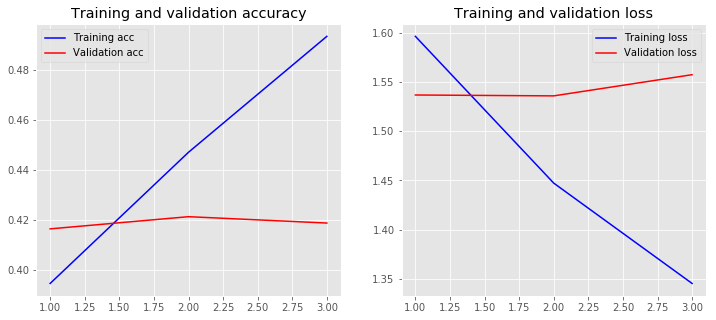

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

embedding_dim = 25
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
#model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.LSTM(56, activation='relu',dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=7,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 25)            443825    
_________________________________________________________________
lstm_1 (LSTM)                (None, 56)                18368     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 399       
Total params: 462,592
Trainable params: 462,592
Non-trainable params: 0
_________________________________________________________________
Train on 108311 samples, validate on 36104 samples
Epoch 1/7
108311/108311 [==============================] - 352s 3ms/step - loss: 1.7232 - acc: 0.3503 - val_loss: 1.6343 - val_acc: 0.3639
Epoch 2/7
101680/108311 [===========================>..] - ETA: 21s - loss: 1.5869 - acc: 0.3920